# Notebook clasificación de imágenes usando Tensorflow.Keras aplicación de aprendizaje profundo (Redes neuronales convolucionales)
**Palabras clave:
Análisis de Imágenes,
Unidad de procesamiento gráfico (GPU, por sus siglas en inglés),
aprendizaje profundo (Red neuronal convolucional),
característica operativa del receptor (curva ROC, por sus siglas en inglés),
Accuracy**

In [14]:
import pandas as pd #Biblioteca para importar datos.
import numpy as np #Biblioteca para crear arreglos.
from matplotlib import pyplot as plt #Biblioteca para plotear.
from IPython.display import Image #Biblioteca para mostrar imágenes.
import tensorflow as tf #Biblioteca para crear modelos de máquinas de aprendizaje.
import keras # Biblioteca Keras es una API de aprendizaje profundo escrita en Python, que se ejecuta sobre la plataforma de aprendizaje automático TensorFlow
from tensorflow.keras import layers # Biblioteca para crear capas, las cuales son componentes básicos de las redes neuronales en Keras
from tensorflow.keras.models import Sequential #Biblioteca para crear modelos secuenciales.
from keras.layers import Conv2D, MaxPool2D, Activation #Biblioteca para importar capas convolucionales, max pooling y funciones de activación
from keras.layers import Dropout, Dense, Flatten, BatchNormalization #Biblioteca para importar Dropout(establece aleatoriamente las unidades de entrada), Flatten (tranformación de mapa de características a un vector columna), y  BatchNormalization La normalización por lotes aplica una transformación entre 0-1
#from google.colab import drive #Biblioteca para importar datos desde google drive.
from keras.layers import Dense #Biblioteca para crear las capas de las redes neuronales (Una capa consta de una función de cálculo de tensor de entrada y tensor de salida).
from keras.optimizers import Adam #Biblioteca del optimizador que implementa el algoritmo Adam.
from tensorflow.keras.applications import ResNet152V2  # Biblioteca para usar modelos entrenados
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout  # Biblioteca para denifir modelos de capas
from keras.callbacks import ModelCheckpoint, EarlyStopping  # Biblioteca para objeto que puede realizar acciones en varias etapas de entrenamiento
from keras.models import load_model # Biblioteca para cargar modelos de entrenamiento .h5
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Autores:
##Martínez Felipe Miguel de Jesús

#El siguiente conjunto de datos se obtuvo de la referencia [1], acontinuación se presentan su uso, el cual es únicamente para fines didácticos


#Consideraciones:
#Si se desea implementar una tarjeta gráfica de vídeo para acelerar el entrenamiento de la red neuronal, se recomienda ver el siguiente link para ver versiones de software [3]

Mounted at /content/drive


**Impresión de la versión de TensorFlow e implementación de GPU (considerar installar controladores nvidia y revisar versión de TensorFlow)**

**En caso de no ocupar GPU entonces: [Ir a Descarga de archivos](#descarga)**


In [15]:
print(tf.__version__)

2.13.0


In [16]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [17]:
tf.test.is_built_with_cuda()

True

In [18]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [19]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [20]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [21]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


**Obtención de las imágenes de rostro de animales [1], Dataset_Animals.zip?rlkey=zo9qhjm3yvopx7wdqmbui83xz&dl=0** <a id='descarga'></a>


In [22]:
#!wget https://www.dropbox.com/scl/fi/xgxt0a4dwuu57ttqhy7hn/Dataset_Animals.zip?rlkey=zo9qhjm3yvopx7wdqmbui83xz&dl=0 -O Dataset_Animals.zip

**Ahora se descromprime el archivo Dataset_Animals.zip?rlkey=zo9qhjm3yvopx7wdqmbui83xz en la ruta**


In [23]:
#!unzip Dataset_Animals.zip?rlkey=zo9qhjm3yvopx7wdqmbui83xz

**Se definen las carpetas que contienen las imágenes de entrenamiento y las imágenes de prueba**

In [24]:
train_dir = '/content/drive/MyDrive/Train' # Datos de entrenamiento
test_dir = '/content/drive/MyDrive/Test'  #Datos de Prueba

**Se establecen los parámetros de las imágenes**

In [25]:
batch_size = 64 # Inicialmente 64
img_height = 1920
img_width = 1080

**Con ayuda de la biblioteca tf.keras se realiza la adquisición de las imágenes que se encuentran en un directorio en específico**

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, #ruta de la carpeta con imágenes
    validation_split=0.3, #70% para el conjunto de entrenamiento y 30% para el conjunto de prueba
    subset='training', # categoría entrenamiento
    seed=123, # Semilla aleatoria opcional
    image_size=(img_height, img_width), #Tamaño de las imágenes
    batch_size=batch_size) #Tamaño de lote de datos, si no se específica entonces de determina 32

Found 304 files belonging to 3 classes.
Using 213 files for training.


In [27]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir, #ruta de la carpeta con imágenes
  validation_split=0.3, #70% para el conjunto de entrenamiento y 30% para el conjunto de prueba
  subset="validation", # categoría validación (prueba)
  seed=123, #Semilla aleatoria opcional
  image_size=(img_height, img_width), #Tamaño de las imágenes
  batch_size=batch_size) #Tamaño de lote de datos, si no se específica entonces de determina 32


Found 60 files belonging to 3 classes.
Using 18 files for validation.


**Se imprimen las clases para clasificación**

In [28]:
class_names = train_ds.class_names
print(class_names)

['AlanFrames', 'IanFrames', 'PabloFrames']


**Se plotea una muestra de 9 imágenes a clasificar**

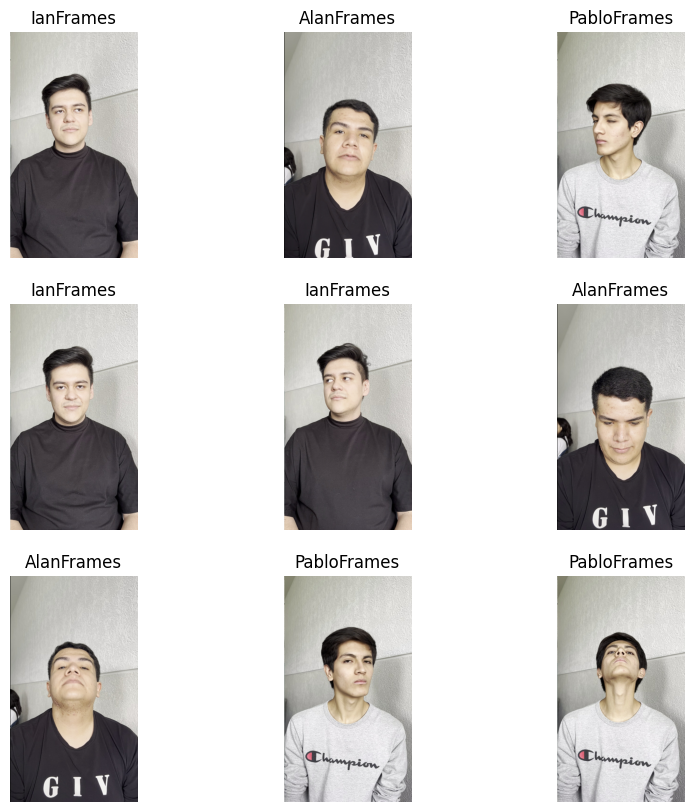

In [29]:
plt.figure(figsize= (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [30]:
#for image_batch, labels_batch in train_ds:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break

**Para escalar una entrada en el rango [0, 255] para que esté en el rango [0, 1], pasaría scale=1./255**


In [31]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


**Corroboramos que los datos de entrenamiento esten normalizados**

$\LARGE x_{escala} = \frac{x-x_{min}}{x_{max}-x_{min}}$

In [32]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
X_train, y_train = next(iter(normalized_ds))
first_image = X_train[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [33]:
normalized_test = test_ds.map(lambda x, y: (normalization_layer(x), y))
X_test, y_test = next(iter(normalized_test))
first_img = X_test[0]
print(np.min(first_img), np.max(first_img))

0.0 1.0


**Haciendo uso de la biblioteca tf.keras.utils.to_categorical, asignamos los datos de entrenamiento y prueba para etiquetar cada valor en la clase correspondiente.**

Nota: en este notebook tenemos 3 clases ['cat', 'dog', 'wild']

In [34]:
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)

# Modelo 1

**Se genera un modelo de red neuronal convolucional**

**3 capas de convolución**

**3 capas de Max pooling**

**1 capa Flatten**

**3 capas de Densas**

**En cuanto al optimizador se ocupa el descenso por gradiente estocástico ADAM [2]**

In [39]:
model = Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(1920, 1080, 3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dense(units=3, activation="softmax")
])

#img_height = 1920
#img_width = 1080

#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss = 'CategoricalCrossentropy',
                   metrics = ['accuracy']) #0.001-> Default, batch_size -> Default 32

In [40]:
#model.summary()

**Se imprime el modelo de la red neuronal convolucional**

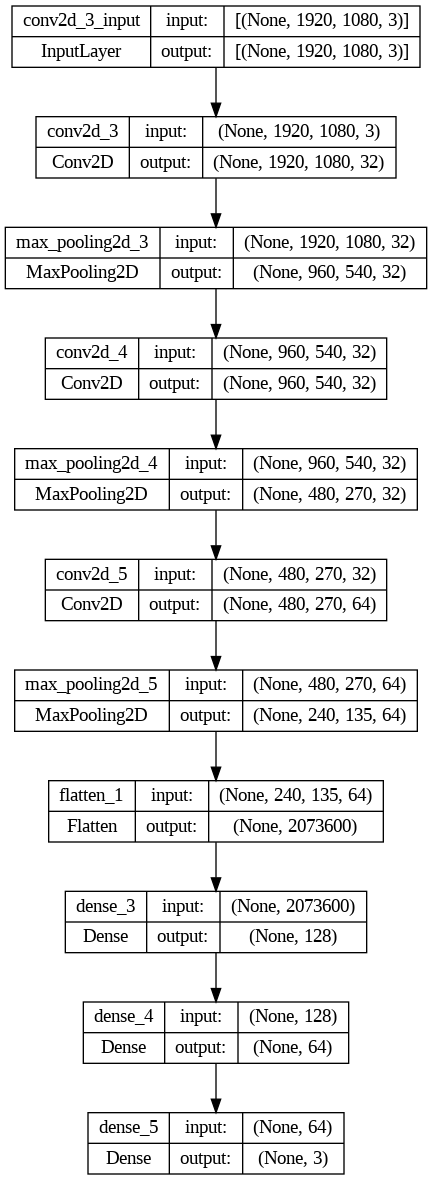

In [41]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True) #pip install pydot

**El modelo de entramiento se realiza con un tamaño de muestra de 32 datos por default que conforman las características, con la finalidad de encontrar el mejor resultado (prueba y error).**

**Se realiza un entrenamiento con 30 epocas a iterar.**

In [ ]:
 history = model.fit(
    X_train, y_train, # Datos de entrenamiento
    epochs = 30, #Número de epocas
    validation_data=(X_test, y_test), #Se asigan los datos de validación
    verbose=1 #verbosidad. 0 = sin impresión, 1 = barra de progreso, 2 = una línea por época.
)

Epoch 1/30


In [ ]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Modelo 2

In [ ]:
model = Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(512, 512, 3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dense(units=3, activation="softmax")
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss = 'CategoricalCrossentropy',
                   metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
 history = model.fit(
    X_train, y_train,
    epochs = 15,
    validation_data=(X_test, y_test),
    verbose=1,
    batch_size=16
)

In [ ]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False,batch_size=16)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False,batch_size=16)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Modelo 3 ResNet152V2 Red neuronal convolucional entrenada [4]

In [ ]:
##### Se específica el nombre del modelo "ResNet152V2".
name = "ResNet152V2"

# Se carga el modelo ResNet152V2 preentrenado, estableciendo sus pesos y excluyendo su capa de clasificación final.
base_model = ResNet152V2(include_top=False, input_shape=(512,512,3), weights='imagenet')
base_model.trainable = False

#Se crea un modelo secuencial con el modelo base ResNet152V2, una capa de agrupación promedio global, dos capas completamente conectadas y una capa de clasificación softmax final.
resnet152V2 = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
], name=name)

# Se compila el modelo con entropía cruzada categórica dispersa como función de pérdida, optimizador de Adam y precisión como métrica de evaluación.
resnet152V2.compile(
    loss='CategoricalCrossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Se configuran las devoluciones de llamada EarlyStopping y ModelCheckpoint para monitorear el proceso de capacitación y guardar los mejores pesos de modelo.
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Se entrena el modelo usando los conjuntos de datos de entrenamiento y validación, usando 15 épocas y las devoluciones de llamadas definidas previamente.
history = resnet152V2.fit(
    X_train, y_train,
    epochs = 15,
    validation_data=(X_test, y_test),
    verbose=1,
    batch_size=32,
    callbacks=cbs
)

In [ ]:
#resnet152V2.summary()

In [ ]:
tf.keras.utils.plot_model(resnet152V2, 'model.png', show_shapes=True) #pip install pydot

In [ ]:
loss, accuracy = resnet152V2.evaluate(X_train,y_train, verbose=False) #batch_size=32
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = resnet152V2.evaluate(X_test,y_test, verbose=False)#batch_size=32
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Se establece la ruta del archivo al modelo pre-entrenado
model_file_path = '/content/ResNet152V2.h5'

# Se carga el modelo pre-entrenado
loaded_model = load_model(model_file_path)

#Imprimero el resumen del modelo ResNet152V2.h5 para clasificación de gatitos,perritos y animales salvajes
loaded_model.summary()

In [ ]:
#!nvidia-smi --help

In [ ]:
#!nvidia-smi -q -g 0 -d UTILIZATION -l 1
!nvidia-smi
#!nvidia-smi --help

# Referencias

[1] Choi, Y., Uh, Y., Yoo, J., & Ha, J.-W. (2020). StarGAN v2: Diverse Image Synthesis for Multiple Domains. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Diederik P. Kingma, & Jimmy Ba. (2017). Adam: A Method for Stochastic Optimization.

[3] https://docs.nvidia.com/deeplearning/frameworks/tensorflow-release-notes/rel_22-06.html

[4] Kaiming He, Xiangyu Zhang, Shaoqing Ren, & Jian Sun. (2016). Identity Mappings in Deep Residual Networks.
